# Single time series analysis

This notebook is used to plot and analyse single simulations from the heatmaps in detail. The landscapes, parameters, random seed and initialisation data for the respective simulation are imported from the "Data" folder and the exact same simulation is repeated.

In [1]:
# load needed packages
import random as rd
import numpy as np
import pandas as pd
from scipy import integrate as integ
import spatial_eco_evo_functions_random as fct_rgg
import spatial_eco_evo_functions_grid as fct_grid
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Define simulation under consideration

In [2]:
landscape="random"  # "random"/"grid"
rep = 7
N = 9
h = 2.0
delta_max = 0.0
evolution = True    # True/False

## 2. Load data

### Coordinates and landscape matrix:

In [3]:
if landscape == "random":
    coordinates = pd.read_excel("Data/" + str(landscape) + "/" + str(rep) + "/N=" + str(N) + "/N=" + str(N) + ",lsc=" + str(landscape) + ".xlsx", 
                                sheet_name='Coordinates')
    # extract x and y
    x_coord = coordinates.values[:,1]
    y_coord = coordinates.values[:,2]
    
    
    delta = pd.read_excel("Data/" + str(landscape) + "/" + str(rep) + "/N=" + str(N) + "/N=" + str(N) + ",lsc=" + str(landscape) + ".xlsx", 
                          sheet_name='Delta')
    # extract values
    delta = delta.values[:,1:]
    
if landscape == "grid":
    x_coord, y_coord, delta, delta_boundary, neighbours = fct_grid.landscape_grid(N)

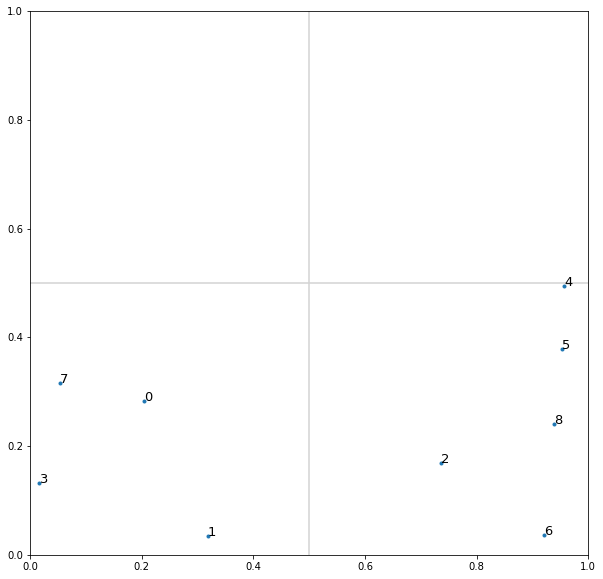

In [4]:
# plot
plt.figure(figsize=(10,10))
plt.plot(x_coord, y_coord, ".")
for i in range(N):
    text(x_coord[i], y_coord[i], i, size=13)
plt.plot(np.linspace(0,1,10), np.linspace(0.5,0.5,10), 'lightgrey')
plt.plot(np.linspace(0.5,0.5,10), np.linspace(0,1,10), 'lightgrey')
plt.xlim(0,1)
plt.ylim(0,1);

To plot the landscape with links in Netlogo activate and run the following cell:

### Parameters:

In [5]:
parameters = pd.read_excel("Data/" + str(landscape) + "/" + str(rep) + "/N=" + str(N) + "/N=" + str(N) + ",lsc=" + str(landscape) + ".xlsx", 
              sheet_name='Parameters')
parameters

,Unnamed: 0,N,d,s,gamma_A,gamma_P,c_A,r_A_change,t_interval,mut_step
0,0,9,0.2,2.5,0.2,1,1,-0.000008,20,0.02


In [6]:
# extract values
d = parameters.values[0,2]
s = parameters.values[0,3]
gamma_A = parameters.values[0,4]
gamma_P = parameters.values[0,5]
c_A = parameters.values[0,6]
r_A_change = parameters.values[0,7]
t_interval = parameters.values[0,8]
mut_step = parameters.values[0,9]

# one data point per time step
t_step = 1              

# initial pollinator growth rate
r_Aorig = 0.6  # for comparison with original model
r_A0 = r_Aorig + d

# set extinction threshold
A_ext = 0.0001

### Plant competition coefficients:

In [7]:
c_P_vals = pd.read_csv("Data/" + str(landscape) + "/" + str(rep) + "/N=" + str(N) + "/c_P/c_P, N=" 
                        + str(N) + ",h=" + str(h) + ",lsc=" + str(landscape) + ".csv")
c_P_vals = c_P_vals.values[:,0]

The carrying capacities $K_i$ of the landscape are:

In [8]:
1/c_P_vals

array([0.25190868, 0.27011081, 0.62633667, 1.6019108 , 1.47750595,
       1.9393055 , 1.65293911, 1.20298464, 0.34744271])

In [9]:
mean(1/c_P_vals) # calculate mean carrying capacity

1.0411605415761813

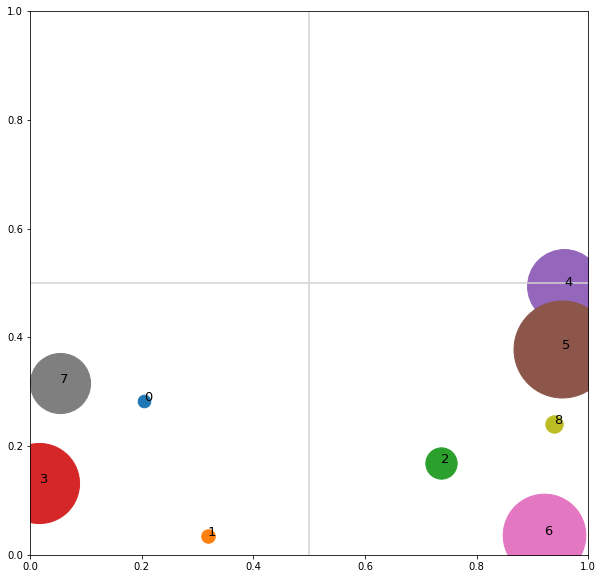

In [10]:
# plot
plt.figure(figsize=(10,10))
for i in range(N):
    plt.plot(x_coord[i], y_coord[i], ".", markersize=100/c_P_vals[i])
    text(x_coord[i], y_coord[i], i, size=13)
i=12
plt.plot(np.linspace(0,1,10), np.linspace(0.5,0.5,10), 'lightgrey')
plt.plot(np.linspace(0.5,0.5,10), np.linspace(0,1,10), 'lightgrey')
plt.xlim(0,1)
plt.ylim(0,1);

### Initialisation data:

Note: For the first replicate with random geometric graphs, the initialisation data were not saved! Here for initialisation activate and run cell below migration matrix calculation.

In [11]:
x0 = pd.read_excel("Data/" + str(landscape) + "/" + str(rep) + "/N=" + str(N) + "/initial/init, N=" + str(N) 
              + ",delta_max=" + str(delta_max) + ",h=" + str(h) + ",lsc=" + str(landscape) + ".xlsx", sheet_name='Densities')
# extract values
x0 = x0.values[:,1]

In [12]:
alpha = pd.read_excel("Data/" + str(landscape) + "/" + str(rep) + "/N=" + str(N) + "/initial/init, N=" + str(N) 
              + ",delta_max=" + str(delta_max) + ",h=" + str(h) + ",lsc=" + str(landscape) + ".xlsx", sheet_name='Alpha values')

# extract values
alpha_max_vals = alpha.values[:,1]
alpha_r_vals = alpha.values[:,2]
alpha_m_vals = alpha.values[:,3]

In [13]:
seeding = pd.read_excel("Data/" + str(landscape) + "/" + str(rep) + "/N=" + str(N) + "/initial/init, N=" + str(N) 
              + ",delta_max=" + str(delta_max) + ",h=" + str(h) + ",lsc=" + str(landscape) + ".xlsx", sheet_name='Seed')

# extract value
seeding = seeding.values[0,1]

## 3. Reproduce time series

Calculate migration matrix:

In [14]:
if landscape == "random":
    # calculate linkwise success
    success = fct_rgg.linkwise_success(delta, delta_max)
    
    # calculate migration frations
    fractions = fct_rgg.fractions_ij(success)
    
    # calculate combined miration matrix
    mig_matrix = success * fractions

if landscape == "grid":
    # calculate linkwise success
    success = fct_grid.linkwise_success(delta_boundary, delta_max, neighbours)
    
    # calculate migration frations
    fractions = fct_grid.fractions_ij(success, neighbours)
    
    # calculation of migration matrix
    mig_matrix = fct_grid.migration_matrix(success, fractions)

### Run simulation:

In [15]:
# prepare empty lists to store simulation results for extinction checks
t_end = 300000
environmental_change = True
x_complete = []
t_complete = []
f_complete = []
r_A_vals = []
alpha_r_complete = []
alpha_m_complete = []
order_of_extinction = np.zeros(N)

# set seed
rd.seed(seeding)
                
for i in range (int(t_end / t_interval)):       # loop through the time intervals

    # calculate per-capita growth rates from alpha
    r_P_r_vals = fct_rgg.r_P_function(alpha_r_vals, alpha_max_vals, s)
    r_P_m_vals = fct_rgg.r_P_function(alpha_m_vals, alpha_max_vals, s)
    
    # t-values for the current time interval, that is between pertubation i and pertubation i+1:
    t = np.arange(0,t_interval,t_step) + i*t_interval
    
    # additional parameters to give into the odeint-function
    env_params = [r_A0, r_A_change, environmental_change]
    plant_params = [alpha_r_vals, r_P_r_vals]
    migration_params =  [d, mig_matrix]
    
    # time series
    x = integ.odeint(fct_rgg.metacommunity,x0,t, 
                    args=(env_params, c_A, c_P_vals, gamma_A, gamma_P, plant_params, migration_params, N))
    
    # calculate and save overall migration success
    f = fct_rgg.overall_migration_success(x, d, mig_matrix, N)
    f = np.repeat(f, t_interval)
    f_complete.extend(f)
    
    
    # check for pollinator extinction:
    x[-1] = np.where(x[-1] < A_ext, 0, x[-1]) # when below extinction threshold send to 0
    
    extinct = np.array(x[-1,::2] < A_ext) # one value per pollinator population: False = alive, True = extinct
    if np.all(extinct): # when all local populations are extinct save the time
        t_extinct = t[-1]
    order_of_extinction = np.where((extinct) & (order_of_extinction == 0), sum(extinct), order_of_extinction)
    
    
    # environmental change for evolution
    if environmental_change:
        r_A = r_A0 + t * r_A_change  
    else:
        r_A = r_A0 + t * 0
        
    r_A_vals.extend(r_A)
    
    # save attractivity values of the current resident populations
    alpha_r_complete.append(alpha_r_vals)
    alpha_m_complete.append(alpha_m_vals)
                        
    # perform evolution if activated
    if evolution:
        alpha_r_vals, alpha_m_vals = fct_rgg.evolution_function(alpha_r_vals, alpha_m_vals, #fct_rgg.
                                                            r_P_r_vals, r_P_m_vals, 
                                                            c_P_vals, r_A[-1], 
                                                            c_A, gamma_P, gamma_A, s, 
                                                            mut_step, d, x[-1])
                    
    # save densities
    x0 = x[-1]    
    x_complete.extend(x)
    t_complete.extend(t)

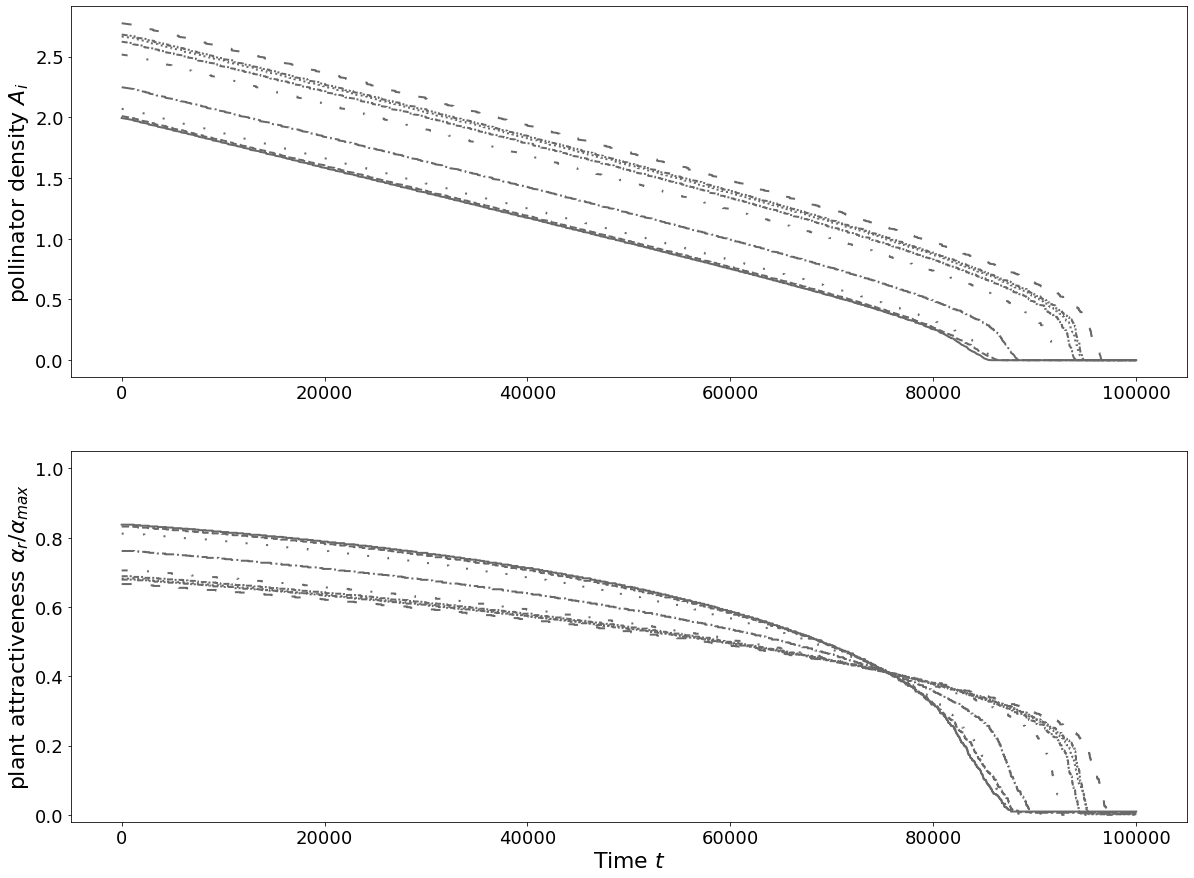

In [16]:
# code for plotting
start=0
end=100000


plt.figure(figsize=(20,15))     
linestyles = ['-', '--', '-.', ':', 
              (0, (3, 1, 1, 1)),  (0, (5, 10)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10)), (0, (1, 10)),
              '-', '--', '-.', ':', (0, (3, 1, 1, 1)),  (0, (5, 10)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10)), (0, (1, 10)),
              '-', '--', '-.', ':', (0, (3, 1, 1, 1)),  (0, (5, 10)), (0, (3, 1, 1, 1, 1, 1))]


# create a first panel for pollinator population densities
plt.subplot2grid((2,1), (0, 0))      
for i in range(N):
    plt.plot(t_complete[start:end],np.asarray(x_complete)[start:end,i*2], color='dimgrey', linestyle=linestyles[i], linewidth=2)
plt.ylabel('pollinator density $A_i$', size=22)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18);


# create a third panel for trait evolution
plt.subplot2grid((2,1), (1, 0))      
for i in range(N):
    plt.plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete, 20, 0))[start:end,i]/alpha_max_vals[i], color='dimgrey', linestyle=linestyles[i], linewidth=2)
plt.ylabel(r'plant attractiveness $\alpha_{r}/\alpha_{max}$', size=22)
plt.xlabel(r'Time $t$', size=22)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.ylim(-0.02, 1.05);

On which habitats did the pollinators die first?

In [17]:
np.argsort(order_of_extinction)

array([0, 8, 1, 2, 7, 4, 3, 6, 5], dtype=int64)

Extended figure including also plant densities, environmental conditions and overall migration success:

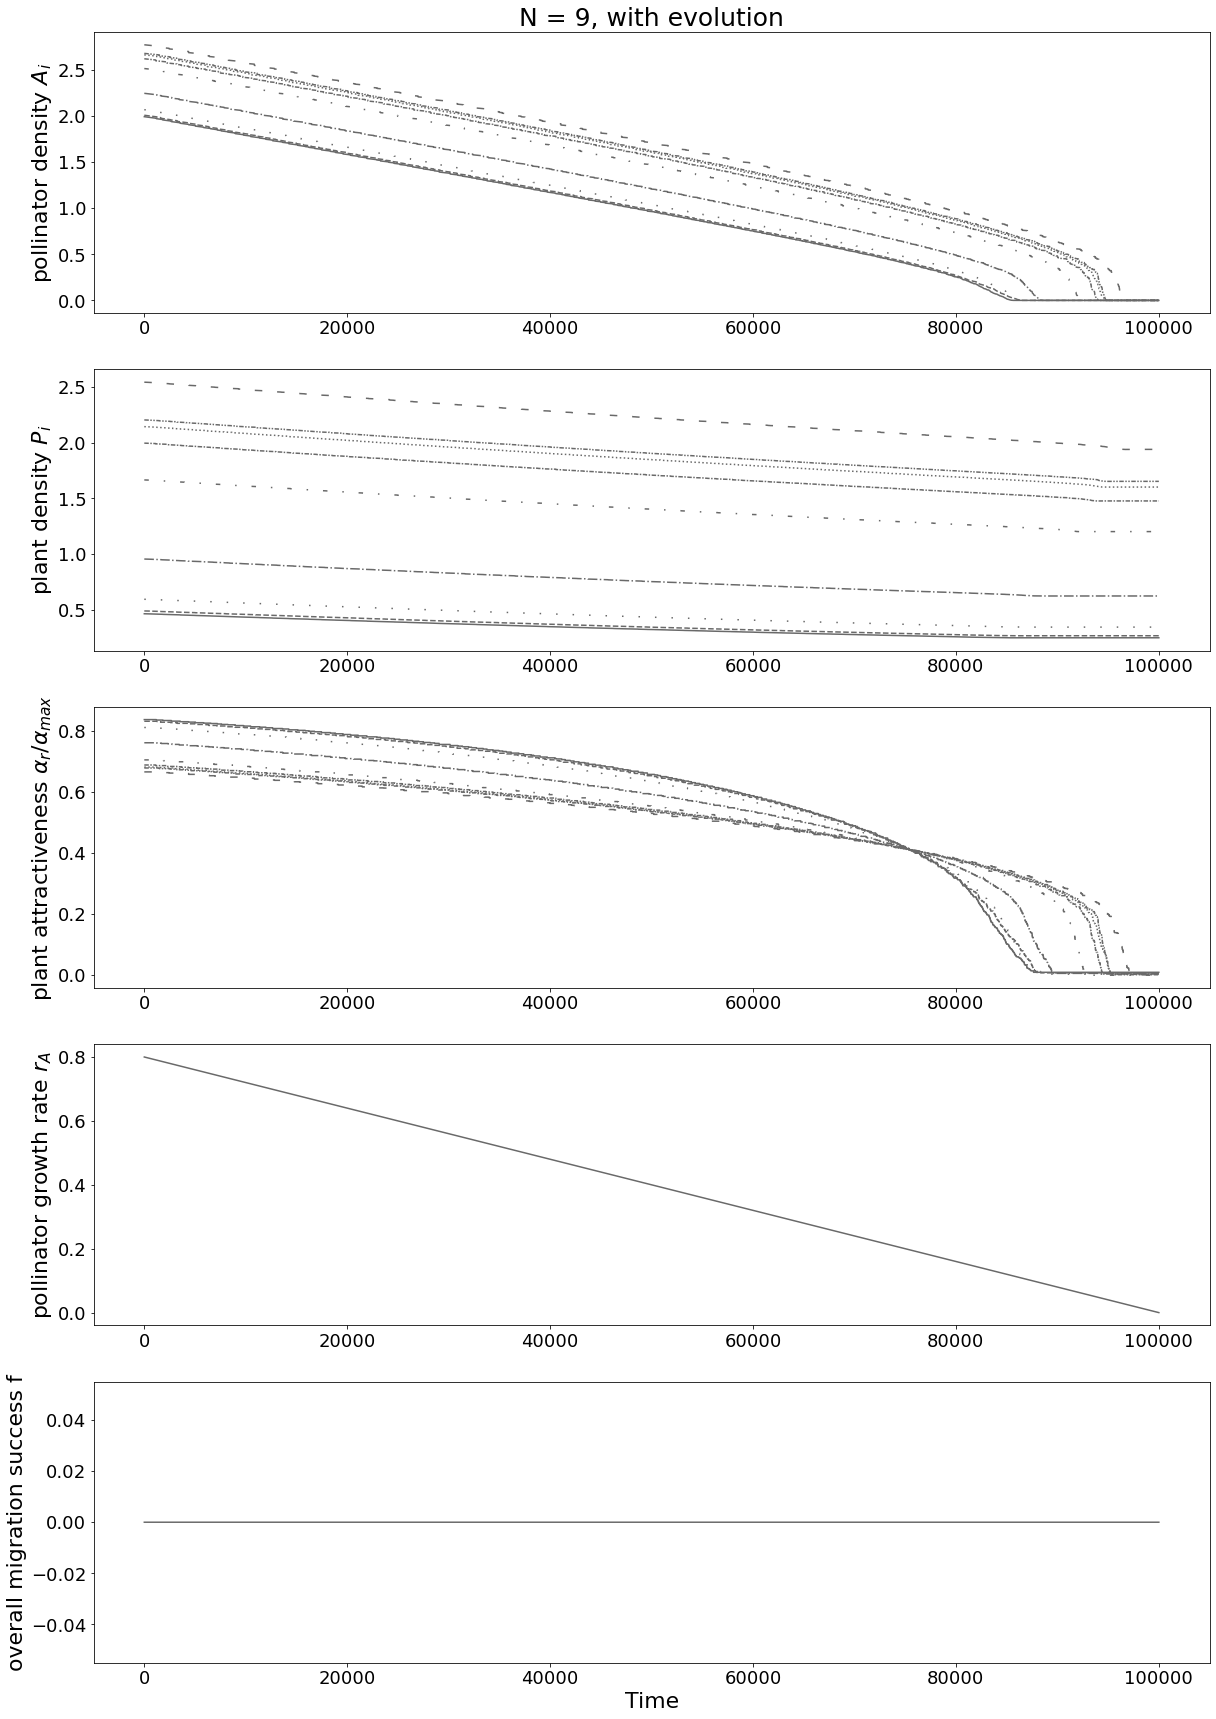

In [18]:
# code for plotting
start=0
end=100000


plt.figure(figsize=(20,30))     
linestyles = ['-', '--', '-.', ':', 
              (0, (3, 1, 1, 1)),  (0, (5, 10)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10)), (0, (1, 10)),
              '-', '--', '-.', ':', (0, (3, 1, 1, 1)),  (0, (5, 10)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10)), (0, (1, 10)),
              '-', '--', '-.', ':', (0, (3, 1, 1, 1)),  (0, (5, 10)), (0, (3, 1, 1, 1, 1, 1))]


# create a first panel for pollinator population densities
plt.subplot2grid((5,1), (0, 0))      
for i in range(N):
    plt.plot(t_complete[start:end],np.asarray(x_complete)[start:end,i*2], color='dimgrey', linestyle=linestyles[i])
    
if evolution == False:
    plt.title('N = ' + str(N) + ', without evolution', fontsize=25)
else:
    plt.title('N = ' + str(N) + ', with evolution', fontsize=25)
plt.ylabel('pollinator density $A_i$', size=22)
plt.tick_params(axis='both', labelsize=18);


# create a second panel for plant population densities
plt.subplot2grid((5,1), (1, 0))      
for i in range(N):
    plt.plot(t_complete[start:end],np.asarray(x_complete)[start:end,i*2+1], color='dimgrey', linestyle=linestyles[i])
plt.ylabel('plant density $P_i$', size=22)
plt.tick_params(axis='both', labelsize=18);


# create a third panel for trait evolution
plt.subplot2grid((5,1), (2, 0))      
for i in range(N):
    plt.plot(t_complete[start:end],np.asarray(np.repeat(alpha_r_complete, 20, 0))[start:end,i]/alpha_max_vals[i], color='dimgrey', linestyle=linestyles[i])
plt.ylabel(r'plant attractiveness $\alpha_{r} / \alpha_{max}$', size=22)
plt.tick_params(axis='both', labelsize=18);


# create a fourth panel for environmental degradation
plt.subplot2grid((5,1), (3, 0))      
plt.plot(t_complete[start:end], r_A_vals[start:end], color='dimgrey') 
plt.ylabel('pollinator growth rate $r_A$', size=22)
plt.tick_params(axis='both', labelsize=18);


plt.subplot2grid((5,1), (4, 0)) 
plt.plot(f_complete[start:end], color='dimgrey')
plt.xlabel('Time', size=22)
plt.ylabel('overall migration success f', size=22)
plt.tick_params(axis='both', labelsize=18);